![contact](https://github.com/ice2ocean/ice2ocean.github.io/blob/master/contact.JPG?raw=true)

### Motivation: 

* Pandas provides powerful data analysis and modeling tools
* however, it is limited to fixed (up to two) dimensional arrays common in finance and social sciences
* in the physical sciences, we often work with multidimensional data
* (see [Rob Story's](https://github.com/wrobstory/pydataseattle2015) talk at PyData Seattle 2015)

![flowchart](https://github.com/ice2ocean/ice2ocean.github.io/blob/master/flowchart.PNG?raw=true)

### xray
* originally developed by employees (Stephan Hoyer, Alex Kleeman and Eugene Brevdo) at [The Climate Corporation](https://climate.com/)
* xray extends some of the core functionality of Pandas:
    * operations over _named_ dimensions
    * selection by label instead of integer location
    * powerful groupby functionality
    * database-like joins

### When to use xray:

* if your data are multidimensional (e.g. climate data: x, y, z, time)
* if your data are structured on a regular grid
* if you can represent your data in NetCDF format

[xray documentation](http://xray.readthedocs.org)

### Why not just numpy?
* joining arrays is awkward in numpy
* labeling is limited to index position
* arrays must be small enough to fit into memory

### Dask:
* many multidimensional datasets are larger-than-memory
* xray recently integrated [Dask](http://xray.readthedocs.org/en/stable/dask.html)
* Dask: parallel computing through task scheduling and blocked algorithms
![daskGraphic](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

![animation](http://mrocklin.github.com/blog/images/dask/embarrassing.gif)

### General package implementation:

* Anaconda distribution
* conda install xray, dask, netCDF4 


### Implementation for this seminar:

* Microsoft Azure Virtual Machine: Linux Ubuntu 14.04 on DS4 VM with 8 cores and 14 GB RAM
* [here's how](https://azure.microsoft.com/en-us/documentation/articles/virtual-machines-python-ipython-notebook/) you deploy Jupyter to the cloud
* cloud deployment:
    * benefit: can easily add resources to handle large datasets
    * cost: success of xray depends on read/write speeds, and some cloud storages throttle speeds based on cost

### Basic xray data structures:
* Dataset: multi-dimensional equivalent of a Pandas DataFrame
    * dict-like container of DataArray objects
![climate](http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png)
* dimensions (x, y, time); variables (temp, precip); coords (lat, long); attributes

### Sample datasets:

* we will use climate reanalysis data from the European Center for Medium Range Weather Forecasts [ECMWF](http://www.ecmwf.int/)
* as is the case for many climate products, the process involves downloading large netcdf files to a local machine
* this example follows and expands from Developer Stephan Hoyer's [blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)

### ECMWF data query interface:
<img src="https://github.com/ice2ocean/ice2ocean.github.io/blob/master/ecmwf.JPG?raw=true" width="400" height="400" />

### File formats
* xray exclusively works with Network Common Data Form or [NetCDF](http://www.unidata.ucar.edu/software/netcdf/) files
* NetCDF files:
    * are self-describing (file layout is described in the header)
    * store data arrays as well as associated metadata
    * allow use of Hierarchical Data Format (HDF) files (after version 4.0)
    * note: different NetCDF versions can impact [reading of data](http://xray.readthedocs.org/en/stable/io.html#netcdf) in xray

### Begin by importing the relevant libraries:

In [1]:
%matplotlib inline 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xray
import xray.ufuncs as xu
import dask
import seaborn as sn
from datetime import datetime
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings('ignore')

### Open the netcdf climate files
* this opens a single netcdf file

In [2]:
ds = xray.open_dataset('/mnt/ecmwf/ecmwf_airtemp.nc')

### Inspect the Dataset contents:

In [8]:
ds

<xray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 13361)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
Data variables:
    t2m        (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...
Attributes:
    Conventions: CF-1.0
    history: 2015-10-19 21:11:12 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-1hbxws.target -o /data/data04/scratch/netcdf-atls05-a562cefde8a29a7288fa0b8b7f9413f7-y_OM5J.nc -utime

## Dimensions
* dimension names for each axis

In [6]:
ds.dims

Frozen(SortedKeysDict({'longitude': 480, 'time': 13361, 'latitude': 241}))

## Coordinates
* a dictionary-like container of arrays labeling each point

In [9]:
ds.coords

Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...

### Inspecting coordinates
* indexing by coordinate dimension returns a data array

In [5]:
ds.coords['time']

<xray.DataArray 'time' (time: 13361)>
array(['1979-01-01T06:00:00.000000000+0000',
       '1979-01-02T06:00:00.000000000+0000',
       '1979-01-03T06:00:00.000000000+0000', ...,
       '2015-07-29T06:00:00.000000000+0000',
       '2015-07-30T06:00:00.000000000+0000',
       '2015-07-31T06:00:00.000000000+0000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
Attributes:
    long_name: time

### Attributes
* DataSets store metadata in an ordered dictionary called _attributes_

In [30]:
ds.attrs

OrderedDict([('Conventions', u'CF-1.0'),
             ('history',
              u'2015-10-29 17:20:47 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-eG3SK6.target -o /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-udfdnE.nc -utime')])

### Attributes

* we can assign new attributes as follows

In [34]:
ds.attrs['title'] = 'example ECMWF dataset'
ds.attrs

OrderedDict([('Conventions', u'CF-1.0'),
             ('history',
              u'2015-10-29 17:20:47 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-eG3SK6.target -o /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-udfdnE.nc -utime'),
             ('title', 'example ECMWF dataset')])

### Data Arrays
* each grid cube/plane represents one data array within the collection comprising the data set
![datasetExample](http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png)

### Data Arrays
* each variable is a separate data array

In [11]:
ds.data_vars

Data variables:
    t2m      (time, latitude, longitude) float64 242.0 242.0 242.0 242.0 ...

### Data Arrays
* when we index a specific variable, it returns a Data Array:

In [24]:
ds['t2m']

<xray.DataArray 't2m' (time: 13361, latitude: 241, longitude: 480)>
dask.array<xray_t2..., shape=(13361, 241, 480), dtype=float64, chunksize=(13361, 241, 480)>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
Attributes:
    long_name: 2 metre temperature
    units: K

### Create a plotting function for visualization
* We use the [cartopy](http://scitools.org.uk/cartopy/) library to make maps

In [3]:
def plotter(DataArray):
    plt.figure(figsize=(9,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.gridlines()
    X = DataArray.coords['longitude'].values
    Y = DataArray.coords['latitude'].values
    pltData = DataArray.values
    plt.pcolormesh(X,Y,pltData,cmap='BrBG')
    plt.colorbar()

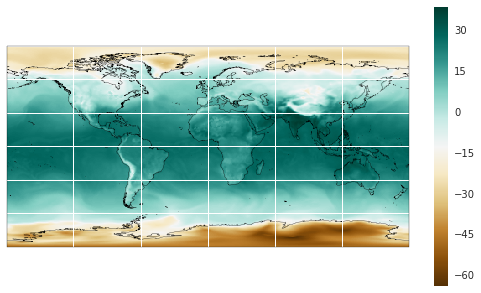

In [4]:
plotter(ds.t2m.isel(time=100)-273.15)

* Note our use of arithmetic operations to convert from Kelvin to degrees Celcius
* This is automatically vectorized across the DataArray, as in numpy

### Data Array: attributes
* in a similar fashion to a Dataset, you can inspect the Data Array coords, dims and attrs

In [33]:
ds['t2m'].attrs

OrderedDict([('long_name', u'2 metre temperature'), ('units', u'K')])

In [35]:
ds.t2m

<xray.DataArray 't2m' (time: 13361, latitude: 241, longitude: 480)>
dask.array<xray_t2..., shape=(13361, 241, 480), dtype=float64, chunksize=(13361, 241, 480)>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
Attributes:
    long_name: 2 metre temperature
    units: K

## Indexing: positional, by integer
* xray supports indexing by position and by labeled dimensions 
* positional indexing: similar to numpy arrays
* note: attributes persist through the indexing operation

In [7]:
ds.t2m[:,0,0]

<xray.DataArray 't2m' (time: 13361)>
array([ 241.95071989,  255.62538883,  248.00456772, ...,  274.85110101,
        275.06312703,  274.81475369])
Coordinates:
    longitude  float32 0.0
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
    latitude   float32 90.0
Attributes:
    units: K
    long_name: 2 metre temperature

## Plot: temperature at one grid cell
* data are extracted to a variable as a numpy array

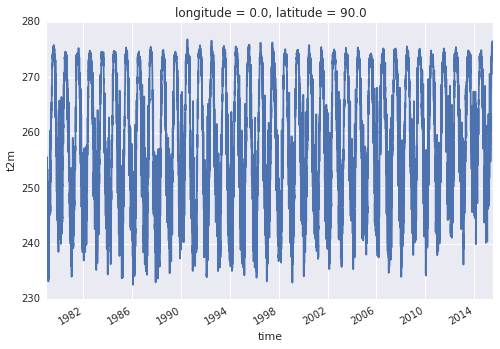

In [8]:
ds.t2m[:,0,0].plot()

## Indexing: positional, by label
* use variable label for the index location (Pandas-like)

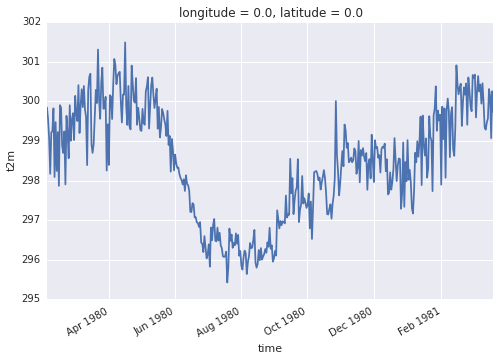

In [15]:
ds.t2m.loc['1980-02-04':'1981-03-21',0,0].plot()

## Indexing: Labeled dimensions
* no need to rely on dimension order
* method 1:
    * use a dictionary as the argument for positional array indexing (numpy-like)

In [74]:
ds.t2m[dict(time=slice(0,100),latitude=slice(50,55),longitude=slice(10,12))]

<xray.DataArray 't2m' (time: 100, latitude: 5, longitude: 2)>
dask.array<getitem..., shape=(100, 5, 2), dtype=float64, chunksize=(100, 5, 2)>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 52.5 51.75 51.0 50.25 49.5
  * longitude  (longitude) float32 7.5 8.25
Attributes:
    long_name: 2 metre temperature
    units: K

## Indexing: Labeled dimensions
* method 2:
    * use a dictionary as the argument for label-based array indexing (Pandas-like)

In [58]:
ds.t2m.loc[dict(time=slice("1992-01-02","1993-09-25"),
                latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))]

<xray.DataArray 't2m' (time: 633, latitude: 5, longitude: 2)>
dask.array<getitem..., shape=(633, 5, 2), dtype=float64, chunksize=(1, 5, 2)>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-02T06:00:00 1992-01-03T06:00:00 ...
  * latitude   (latitude) float32 52.5 51.75 51.0 50.25 49.5
  * longitude  (longitude) float32 7.5 8.25
Attributes:
    units: K
    long_name: 2 metre temperature

## Indexing: Labeled dimensions
* this syntax is beginning to get cumbersome
* xray has the following convenience methods to tidy up the syntax

In [82]:
#ds.t2m[dict(time=slice(0,100),latitude=slice(50,55),longitude=slice(10,12))]
ds.t2m.isel(time=slice(0,100),latitude=slice(50,55),longitude=slice(10,12))

<xray.DataArray 't2m' (time: 100, latitude: 5, longitude: 2)>
dask.array<getitem..., shape=(100, 5, 2), dtype=float64, chunksize=(100, 5, 2)>
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
  * latitude   (latitude) float32 52.5 51.75 51.0 50.25 49.5
  * longitude  (longitude) float32 7.5 8.25
Attributes:
    long_name: 2 metre temperature
    units: K

In [59]:
#ds.t2m.loc[dict(time=slice("1992-01-02","1993-09-25"),
#                latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))]

ds.t2m.sel(time=slice("1992-01-02","1993-09-25"),
           latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))

<xray.DataArray 't2m' (time: 633, latitude: 5, longitude: 2)>
dask.array<getitem..., shape=(633, 5, 2), dtype=float64, chunksize=(1, 5, 2)>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-02T06:00:00 1992-01-03T06:00:00 ...
  * latitude   (latitude) float32 52.5 51.75 51.0 50.25 49.5
  * longitude  (longitude) float32 7.5 8.25
Attributes:
    units: K
    long_name: 2 metre temperature

## Visualization of indexing applications
* a simple application: spatial subsetting (Alaska region)
* note: we need to [squeeze](http://xray.readthedocs.org/en/stable/generated/xray.DataArray.squeeze.html) the array for plotting purposes

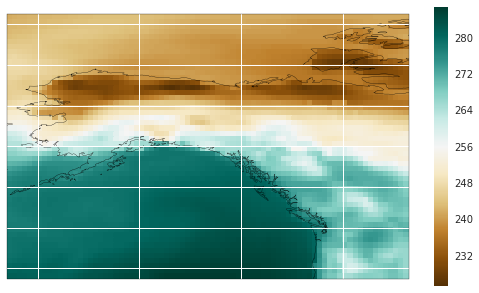

In [60]:
plotData = ds.sel(time="1984-01-01",latitude=slice(80,40)
                  ,longitude=slice(190,250))
plotter(plotData.squeeze(dim='time').t2m)

## Indexing: pointwise
* all indexing so far has involved selection along orthogonal groups
* we can also provide lists to select individual points from the grids

In [17]:
times = pd.to_datetime(['1992-01-02T6:00:00','1992-01-02T6:00:00'])
ds.t2m.sel_points(time=times,latitude=[52.5,60.0],longitude=[7.5,8.25])

<xray.DataArray 't2m' (points: 2)>
array([ 279.83472223,  271.96148919])
Coordinates:
    longitude  (points) float32 7.5 8.25
    time       (points) datetime64[ns] 1992-01-02T06:00:00 1992-01-02T06:00:00
    latitude   (points) float32 52.5 60.0
  * points     (points) int64 0 1
Attributes:
    units: K
    long_name: 2 metre temperature

## Opening multiple netcdf files, and using Dask
* we will use the [mfdataset](http://xray.readthedocs.org/en/stable/generated/xray.open_mfdataset.html#xray.open_mfdataset) option that opens multiple files as a single xray dataset
* this automatically invokes the dask functionality
* in our case, there are multiple files for each parameter

In [6]:
!ls /mnt/ecmwf
ds = xray.open_mfdataset('/mnt/ecmwf/*.nc', engine='scipy')

ecmwf_airtemp.nc  ecmwf_uwind.nc  ecmwf_vwind.nc  mask	SST.nc


## Dataset indexing
* indexing on datasets indexes all variables simulataneously

In [61]:
ds.sel(time=slice("1992-01-02","1993-09-25"),
       latitude=slice(52.5,49.5),longitude=slice(7.5,8.25))

<xray.Dataset>
Dimensions:    (latitude: 5, longitude: 2, time: 633)
Coordinates:
  * latitude   (latitude) float32 52.5 51.75 51.0 50.25 49.5
  * longitude  (longitude) float32 7.5 8.25
  * time       (time) datetime64[ns] 1992-01-02T06:00:00 1992-01-03T06:00:00 ...
Data variables:
    v10        (time, latitude, longitude) float64 -2.297 -1.876 -1.494 ...
    u10        (time, latitude, longitude) float64 7.043 7.548 6.824 7.261 ...
    sst        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    t2m        (time, latitude, longitude) float64 277.5 277.1 276.7 276.0 ...
Attributes:
    history: 2015-10-29 17:20:47 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-eG3SK6.target -o /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-udfdnE.nc -utime
    Conventions: CF-1.0

### Chunk sizes:
* in my testing, getting the chunk size right is the crucial step to optimize Dask
* without specifying chunk size, open_mfdataset chunks along existing dimensions

In [22]:
ds.chunks

Frozen(SortedKeysDict({'time': (13361,), 'longitude': (480,), 'latitude': (241,)}))

### Chunk size:
* recommended: follow the advice [here](http://xray.readthedocs.org/en/stable/dask.html?highlight=rechunk#chunking-and-performance) regarding chunk sizes: about 1 million elements
* in our case: 480* 241 = 115680
* so make the time chunk 10 to get around 1 million
* note: we're only chunking the time dimension. Choice depends on typical slicing scenarios. More testing needed!


In [62]:
ds = xray.open_mfdataset('/mnt/ecmwf/*.nc', engine='scipy', 
                         chunks = {'time':10})

## GroupBy processing
* xray has powerful [GroupBy](http://xray.readthedocs.org/en/stable/groupby.html) processing tools
* this is similar to GROUP BY processing in SQL
* in all cases we **split** the data, **apply** a function to independent groups, and **combine** back into a known data structure

## GroupBy processing: example
* we often want to build a time series of change from spatially distributed data
* let's calculate the average air temperature over the globe for the full time period
* remember: split, apply, combine!

### Groupby processing: split

* we can groupby the name of a variable or coordinate
* this returns an xray groupby object

In [33]:
ds.t2m.groupby('time')

View the group indices:

In [ ]:
ds.t2m.groupby('time').groups

* output looks like this:

{numpy.datetime64('1979-01-02T06:00:00.000000000+0000'): 1,

 numpy.datetime64('1989-03-15T06:00:00.000000000+0000'): 3726,

 numpy.datetime64('2006-03-29T06:00:00.000000000+0000'): 9949,
 
 numpy.datetime64('2004-04-16T06:00:00.000000000+0000'): 9237,

### Groupby processing: apply
* when providing a single dimension to the GroupBy command, xray applies the function across the remaining dimensions
* we could do this:

In [ ]:
def mean(x):
    return x.mean()

ds.t2m.groupby('time').apply(mean).plot()

* however, groupby objects have convenient shortcuts (see next slide)
* but, use this approach if the function is non-standard 

### Groupby processing: apply
* now an acutal calculation: 
    * we'll use dask's [diagnostic tools](http://dask.pydata.org/en/latest/diagnostics.html) to monitor the processing
    * we'll use xray's new [plotting](http://xray.readthedocs.org/en/stable/plotting.html) capabilities
    * when a single dimension is provided, xray applies the function over all dimensions _other than_ that dimension

[########################################] | 100% Completed | 42.2s


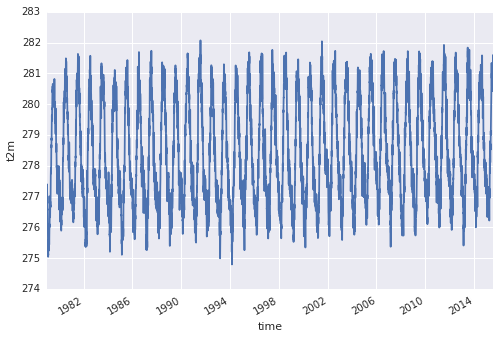

In [30]:
with ProgressBar():
    ds.t2m.groupby('time').mean().plot()

* we can group over any number of [time components](http://xray.readthedocs.org/en/stable/time-series.html#datetime-components)
* here's the global average annual air temperature since 1979 

[########################################] | 100% Completed |  9.2s


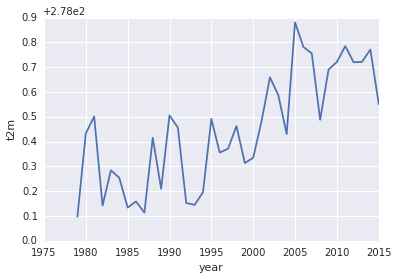

In [42]:
with ProgressBar():
    ds.t2m.groupby('time.year').mean().plot()

### Conversion to Pandas
* we can use ".to_series()" to convert an xray data array to a Pandas data series
* then, use Pandas methods on the series to resample the data

[########################################] | 100% Completed | 47.3s


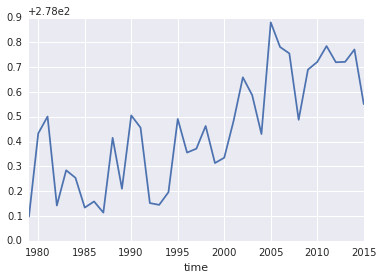

In [53]:
with ProgressBar():
    ds.t2m.groupby('time').mean().to_series().resample('A',how='mean').plot()

### Groupby: advanced temporal grouping
* xray introduces the 'season' time component, common in climate studies
* and it turns out, xray's new [.plot()](http://xray.readthedocs.org/en/stable/plotting.html) functionality operates on spatial maps as well!

* here is the mean differences between summer and winter global temperatures

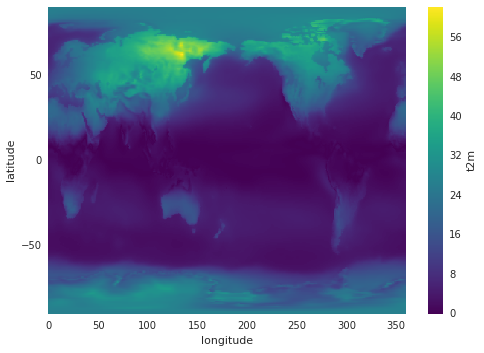

In [8]:
ds_by_season = ds.t2m.groupby('time.season').mean('time')
t2m_range = abs(ds_by_season.sel(season='JJA')
                 - ds_by_season.sel(season='DJF'))
t2m_range.plot()

## Calculation of wind vectors

* xray exposes numpy [ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) commands that can operate on data arrays
* here we'll calculate windspeed from the orthogonal wind vectors

In [9]:
subset = ds.sel(time="1984-01-01",latitude=slice(70,40),
                longitude=slice(200,240)).squeeze(dim='time')
windspeed = xu.sqrt(subset.u10**2+subset.v10**2)

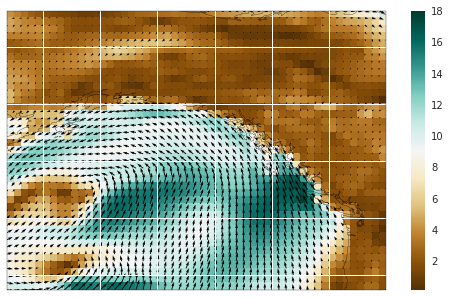

In [10]:
plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.gridlines()
X = windspeed.coords['longitude'].values
Y = windspeed.coords['latitude'].values
plt.pcolormesh(X,Y,windspeed.values,cmap='BrBG')
ax.quiver(X, Y, subset.u10.values, subset.v10.values)
plt.colorbar()

### Masking with WHERE:
* so far we have used indexing to return subsets of the original
* the subset array shape will be different from the original
* however, we often want to retain the array shape and mask out some observations
* applications: remote sensing, land cover modeling

### Masking with WHERE:
* we will use [where()](http://xray.readthedocs.org/en/stable/indexing.html#masking-with-where) for this selection
* question: which grid cells had temperatures > 12 C on June 21, 1984?

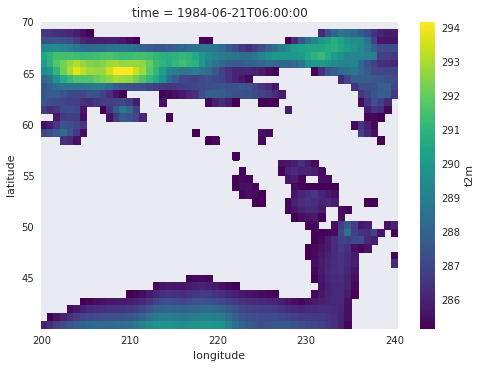

In [23]:
subset = ds.sel(time="1984-06-21",latitude=slice(70,40),longitude=slice(200,240))
subset.t2m.where(subset.t2m > 285.15).plot()

### Masking with WHERE:
* a common Earth science application: creating land cover masks
* next we'll use the sea surface temperature field (sst) to build a land and ocean mask 
* we'll assign land a value of 1, and ocean a value of 2 (arbitrary)

### Land/ocean mask
* the sst field currently has NaN for all land surfaces:

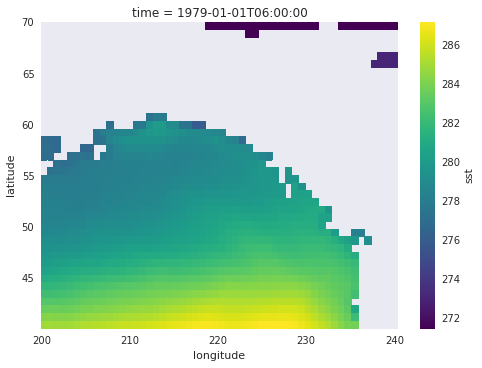

In [65]:
subset = ds.sel(latitude=slice(70,40),longitude=slice(200,240)) # Alaska subset
subset.sst.isel(time=0).plot()

### Buliding the mask:
* here we'll use some lower-level numpy commands to build the mask
* mask number depends on whether the cells are finite or NaN

In [73]:
maskOcean = 2 * np.ones((subset.dims['latitude'],
                         subset.dims['longitude'])) \
                        * np.isfinite(subset.sst.isel(time=0))  

maskLand = 1 * np.ones((subset.dims['latitude'],
                        subset.dims['longitude'])) \
                        * np.isnan(subset.sst.isel(time=0))  

maskArray = maskOcean + maskLand

### Mask as Coordinates
* we can keep the mask as a separate array entity
* or, if we are using it routinely, there are advantages to [adding it](http://xray.readthedocs.org/en/stable/data-structures.html#dataarray-coordinates) as a coordinate to the data array

In [63]:
subset.coords['mask'] = (('latitude','longitude'),maskArray)
subset

<xray.Dataset>
Dimensions:    (latitude: 40, longitude: 54, time: 13361)
Coordinates:
  * latitude   (latitude) float32 69.75 69.0 68.25 67.5 66.75 66.0 65.25 ...
  * longitude  (longitude) float32 200.25 201.0 201.75 202.5 203.25 204.0 ...
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 1979-01-02T06:00:00 ...
    mask       (latitude, longitude) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
Data variables:
    v10        (time, latitude, longitude) float64 5.705 5.696 5.422 5.142 ...
    u10        (time, latitude, longitude) float64 -0.7231 -0.6262 -0.4522 ...
    sst        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    t2m        (time, latitude, longitude) float64 262.5 261.4 259.7 257.7 ...
Attributes:
    history: 2015-10-29 17:20:47 GMT by grib_to_netcdf-1.13.1: grib_to_netcdf /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-eG3SK6.target -o /data/data04/scratch/netcdf-atls00-a562cefde8a29a7288fa0b8b7f9413f7-udfdnE.nc -utime
    C

* Here's a visualization of the land/ocean mask

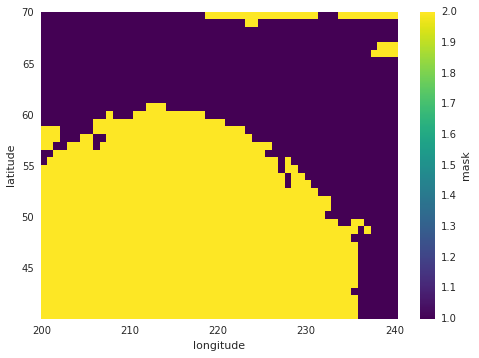

In [64]:
subset.mask.plot()

### Mask as Coordinates
* now we can easily apply the mask using where()
* we can integrate this with statistical functions operating on the array

* this is the mean air temperature over Alaska during the entire period of record

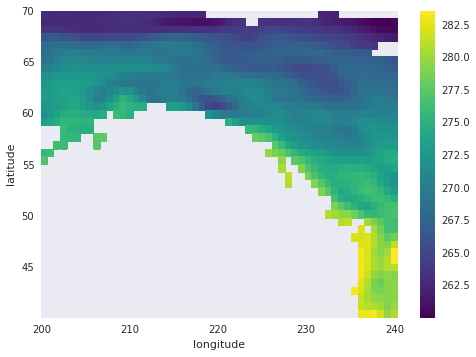

In [49]:
subset.t2m.mean('time').where(subset.mask == 1).plot()

* similarly, this is the mean SST over the full time series

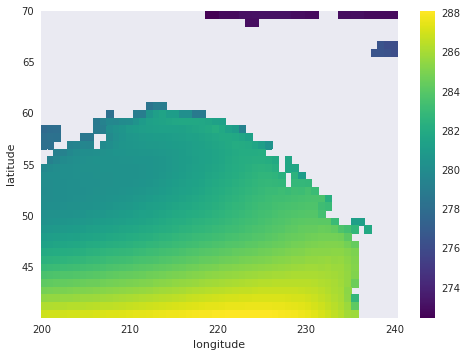

In [50]:
subset.sst.mean('time').where(subset.mask == 2).plot()

### Calculating a climate index:
* climate scientists commonly calculate mean diferences in sea and land surface temperatures
* question: what is the mean annual difference in SST and t2m over the Alaska region? 

In [53]:
landSft = subset.t2m.where(subset.mask == 1).groupby('time.year').mean()
oceanSft = subset.sst.where(subset.mask == 2).groupby('time.year').mean()
landSft

<xray.DataArray (year: 37)>
dask.array<atop-43..., shape=(37,), dtype=float64, chunksize=(1,)>
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 ...

* here's a plot of the index, showing mean annual differences in land/ocean

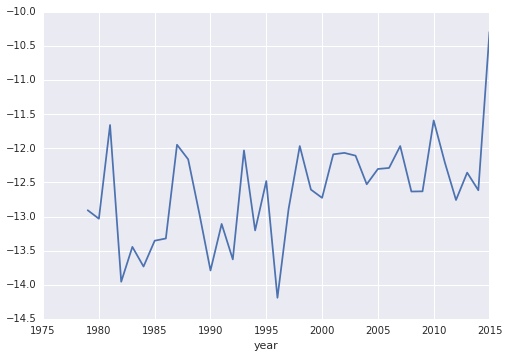

In [54]:
climateIndex = (landSft - oceanSft).plot()

### Groupby on two dimensional mask?
* our mask is 2D (lat, long)
* wouldn't it be useful to groupby this mask directly? 
* this would be more elegant than above, and add some additional flexibility

In [ ]:
subset.t2m.groupby('mask').mean()

* if we run this, there are errors
* the xray team is working on removing the 1-D limitation on groupby operations
* stay tuned!